### Creating the dataset

In [1]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
# Make df of circle

import pandas as pd

df = pd.DataFrame({"X1" : X[:, 0],
                   "X2" : X[:, 1],
                   "label": y})

df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


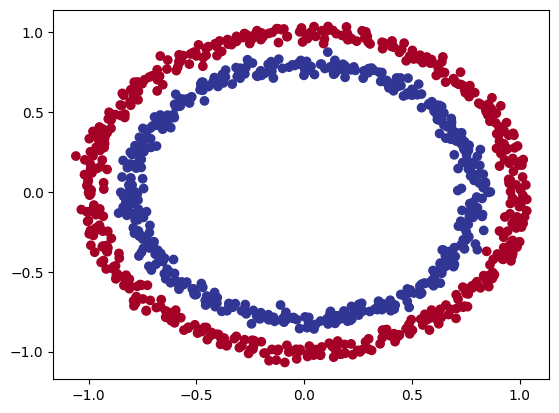

In [5]:
# Visualizing dataset
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### Checking input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
import torch
torch.__version__

'2.4.1+cu121'

In [8]:
# Turning data into tensors

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

type(X), type(y)

(torch.Tensor, torch.Tensor)

In [9]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [11]:
# Creating train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
import torch
from torch import nn

In [15]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [16]:
# Archtecture of the model: 2 linear layers

class CircleModel_0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x))


In [17]:
circle_model_0 = CircleModel_0().to(device)
circle_model_0

CircleModel_0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
# Making the same model using nn.Sequential

circle_model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

circle_model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
circle_model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6709, -0.1805],
                      [-0.6939,  0.4907],
                      [ 0.3981,  0.4756],
                      [-0.0368, -0.2802],
                      [-0.5323, -0.6000]])),
             ('0.bias', tensor([-0.2851, -0.3564, -0.1958,  0.0308, -0.3032])),
             ('1.weight',
              tensor([[ 0.1014, -0.3627,  0.3822, -0.2831,  0.2486]])),
             ('1.bias', tensor([-0.2617]))])

In [20]:
# Making untrined preds

with torch.inference_mode():
  untrained_preds = circle_model_1(X_test)
  print(f"Untrained preds: {untrained_preds[:5]}")
  print(f"Originial labels: {y_test[:5]}")

Untrained preds: tensor([[-0.5091],
        [-0.3958],
        [-0.5396],
        [-0.5016],
        [-0.1167]])
Originial labels: tensor([1., 0., 1., 0., 1.])


In [21]:
loss_func = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params=circle_model_1.parameters(),
                             lr=0.01)

In [22]:
def get_accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [23]:
circle_model_1.eval()
with torch.inference_mode():
  y_logits = circle_model_1(X_test)[:5]

y_logits

tensor([[-0.5091],
        [-0.3958],
        [-0.5396],
        [-0.5016],
        [-0.1167]])

In [24]:
# We dont want them in logits form, but in probabilty form

circle_model_1.eval()
with torch.inference_mode():
  y_logits = circle_model_1(X_test)
y_pred_probs = torch.sigmoid(y_logits)
y_pred_labels = torch.round(y_pred_probs)
y_pred_labels[:5], y_pred_probs[:5]

(tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]]),
 tensor([[0.3754],
         [0.4023],
         [0.3683],
         [0.3772],
         [0.4709]]))

In [25]:
# Training Loop

epochs = 500

for epoch in range(epochs):
  circle_model_1.train()

  # Forward pass
  y_logits = circle_model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculating loss
  loss = loss_func(y_logits,
                   y_train)

  acc = get_accuracy(y_true=y_train,
                     y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Testing

  circle_model_1.eval()

  with torch.inference_mode():
    test_logits = circle_model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_func(test_logits,
                          y_test)

    test_acc = get_accuracy(y_true=y_test,
                                y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss} | Training Loss: {acc} | Test Loss: {test_acc}")


Epoch: 0 | Loss: 0.7120285630226135 | Test Loss: 0.7112624645233154 | Training Loss: 42.625 | Test Loss: 44.0
Epoch: 10 | Loss: 0.694388210773468 | Test Loss: 0.6975547075271606 | Training Loss: 48.5 | Test Loss: 49.0
Epoch: 20 | Loss: 0.6933431029319763 | Test Loss: 0.6946256160736084 | Training Loss: 52.125 | Test Loss: 51.5
Epoch: 30 | Loss: 0.6933215260505676 | Test Loss: 0.6937474608421326 | Training Loss: 51.87500000000001 | Test Loss: 52.0
Epoch: 40 | Loss: 0.692980945110321 | Test Loss: 0.6949283480644226 | Training Loss: 51.125 | Test Loss: 45.5
Epoch: 50 | Loss: 0.6930233836174011 | Test Loss: 0.6950729489326477 | Training Loss: 50.24999999999999 | Test Loss: 46.5
Epoch: 60 | Loss: 0.6929864287376404 | Test Loss: 0.6946072578430176 | Training Loss: 50.5 | Test Loss: 45.5
Epoch: 70 | Loss: 0.6929827928543091 | Test Loss: 0.6946645379066467 | Training Loss: 51.24999999999999 | Test Loss: 47.5
Epoch: 80 | Loss: 0.6929812431335449 | Test Loss: 0.6946558356285095 | Training Loss: 

In [26]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


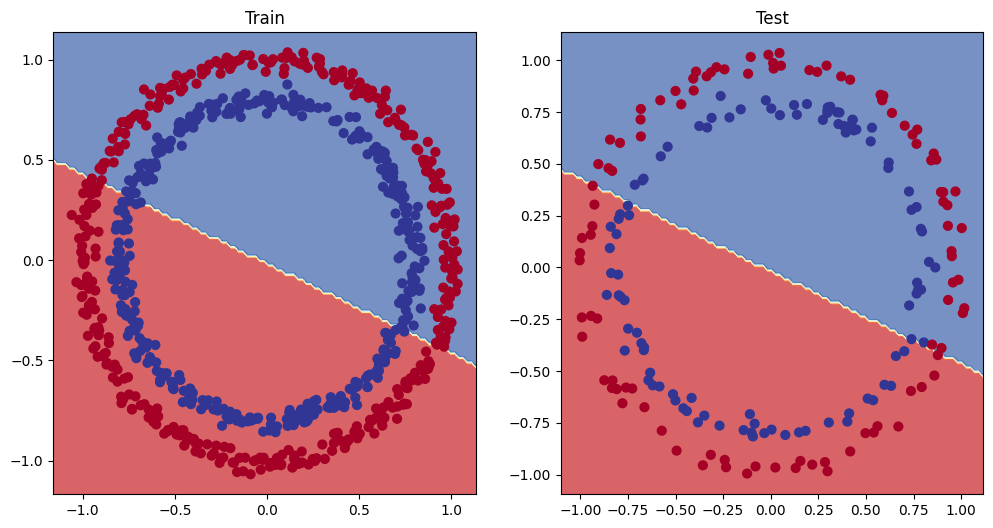

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(circle_model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(circle_model_1, X_test, y_test)

###  Improving a model

* Add more layers
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Changing the learning rate
* Changing the loss function

These changes are from model's perspective. These are knows as **hyperparameters**

In [28]:
class CircleModel_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor :
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)

    return z

In [29]:
circle_model_2 = CircleModel_2()

circle_model_2.to(device)

CircleModel_2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
loss_func = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=circle_model_2.parameters(), lr=0.01)

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  circle_model_2.train()

  y_logits = circle_model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_func(y_logits, y_train)
  acc = get_accuracy(y_true=y_train,
                     y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  circle_model_2.eval()

  with torch.inference_mode():
    test_logits = circle_model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_func(test_logits, y_test)
    test_acc = get_accuracy(y_true=y_test,
                     y_pred=test_pred)


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Accuracy: {acc:.5f}% | Test accuracy: {test_acc:.5f}% | Loss: {loss:.2f} | Test Loss: {test_loss:.2f}")

Epoch: 0 | Accuracy: 50.00000% | Test accuracy: 50.00000% | Loss: 0.69 | Test Loss: 0.70
Epoch: 100 | Accuracy: 50.00000% | Test accuracy: 50.00000% | Loss: 0.69 | Test Loss: 0.69
Epoch: 200 | Accuracy: 45.75000% | Test accuracy: 49.50000% | Loss: 0.69 | Test Loss: 0.69
Epoch: 300 | Accuracy: 49.62500% | Test accuracy: 47.50000% | Loss: 0.69 | Test Loss: 0.69
Epoch: 400 | Accuracy: 50.37500% | Test accuracy: 47.00000% | Loss: 0.69 | Test Loss: 0.69
Epoch: 500 | Accuracy: 50.87500% | Test accuracy: 46.50000% | Loss: 0.69 | Test Loss: 0.69
Epoch: 600 | Accuracy: 50.87500% | Test accuracy: 46.00000% | Loss: 0.69 | Test Loss: 0.69
Epoch: 700 | Accuracy: 51.25000% | Test accuracy: 45.50000% | Loss: 0.69 | Test Loss: 0.69
Epoch: 800 | Accuracy: 51.12500% | Test accuracy: 47.00000% | Loss: 0.69 | Test Loss: 0.69
Epoch: 900 | Accuracy: 51.25000% | Test accuracy: 47.00000% | Loss: 0.69 | Test Loss: 0.69


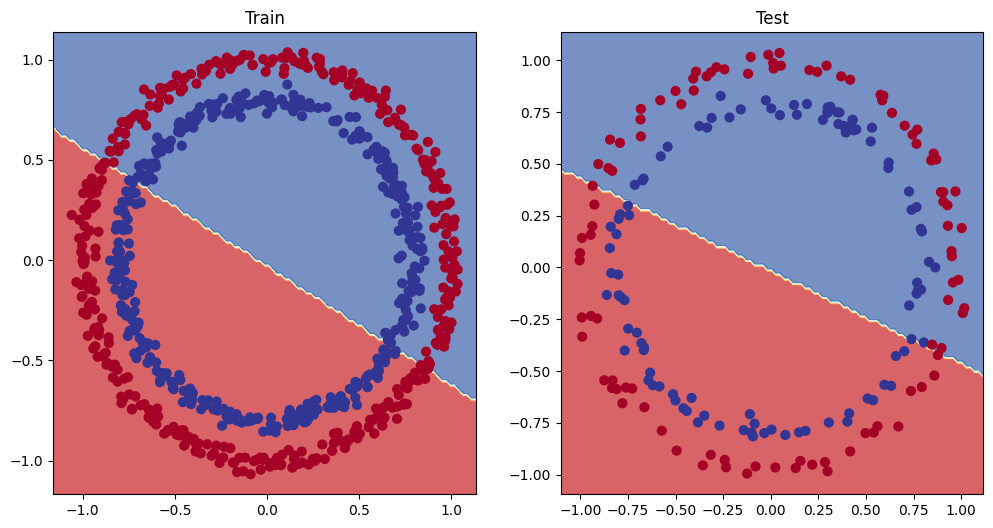

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(circle_model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(circle_model_1, X_test, y_test)

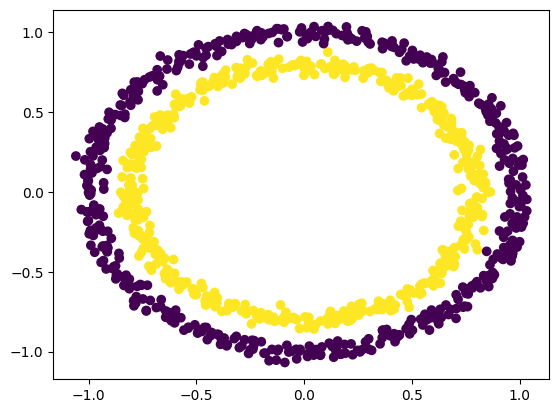

In [33]:
# Finally introducing non lineaarity into the model

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    random_state=42,
                    noise=0.03)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [34]:
# Converting to tensors

import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [35]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [36]:
from torch import nn

class CircleModelNonLinear(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=8)
    self.layer_3 = nn.Linear(in_features=8, out_features=1)

    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_non_linear = CircleModelNonLinear().to(device)
model_non_linear

CircleModelNonLinear(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [37]:
optimizer = torch.optim.Adam(params=model_non_linear.parameters(), lr=0.01)

loss_func = nn.BCEWithLogitsLoss()

optimizer, loss_func

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0
 ),
 BCEWithLogitsLoss())

In [38]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [39]:
# Training loop

epochs = 100

for epoch in range(epochs):

  model_non_linear.train()

  y_logits = model_non_linear(X_train).squeeze()
  loss = loss_func(y_logits, y_train)

  y_pred = torch.round(torch.sigmoid(y_logits))

  accuracy = get_accuracy(y_pred=y_pred,
                          y_true=y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_non_linear.eval()

  with torch.inference_mode():
    test_logits = model_non_linear(X_test).squeeze()
    test_loss = loss_func(test_logits, y_test)
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_accuracy = get_accuracy(y_pred=test_pred,
                          y_true=y_test)


  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss} | Accuracy: {accuracy} | Test Accuracy: {test_accuracy}")


Epoch: 0 | Loss: 0.6926532983779907 | Test Loss: 0.6893978118896484 | Accuracy: 50.0 | Test Accuracy: 53.0
Epoch: 50 | Loss: 0.5136919021606445 | Test Loss: 0.5115060210227966 | Accuracy: 83.25 | Test Accuracy: 83.0


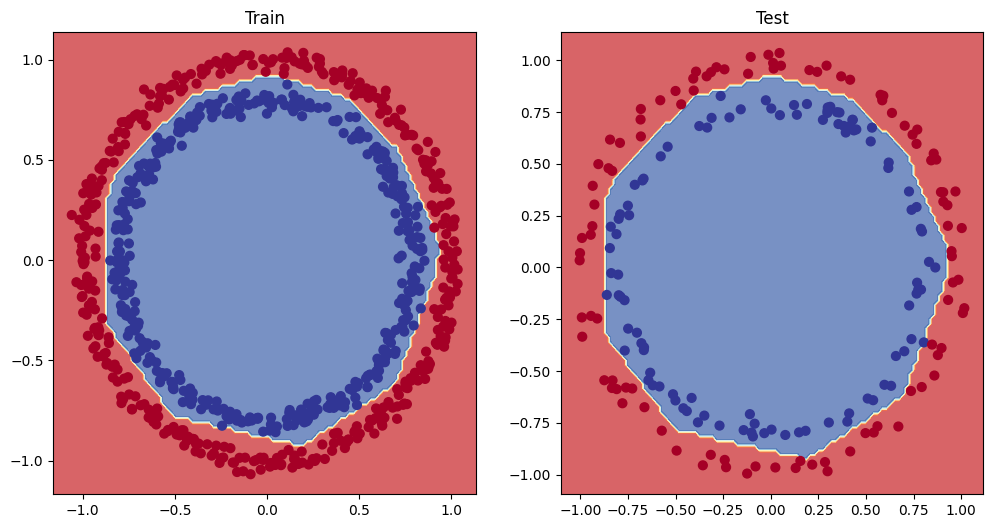

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_non_linear, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_non_linear, X_test, y_test)

### Putting it all together with a multi class classification

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [42]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

SEED = 42
NUM_CLASSES = 4
NUM_FEATURES = 2

n_samples = 1000

X, y = make_blobs(n_samples=n_samples, n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=SEED,
                  cluster_std=1.5)

In [43]:
X[:5], y[:5]

(array([[-8.41339595,  6.93516545],
        [-5.76648413, -6.43117072],
        [-6.04213682, -6.76610151],
        [ 3.95083749,  0.69840313],
        [ 4.25049181, -0.28154475]]),
 array([3, 2, 2, 1, 1]))

In [44]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

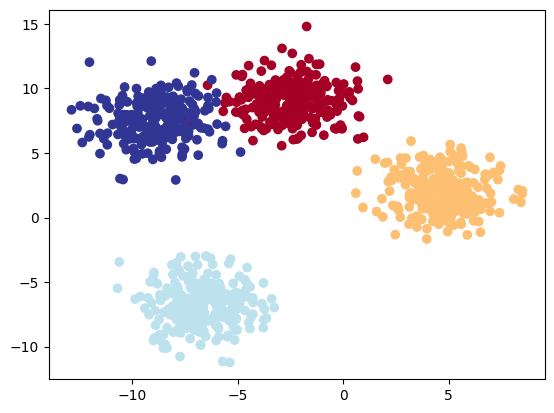

In [46]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [47]:
# Creating model

class MultiClassModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)


In [48]:
blob_model = MultiClassModel(input_features=2,
                            output_features=NUM_CLASSES,
                            hidden_units=8).to(device)

blob_model

MultiClassModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [49]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=blob_model.parameters(), lr=0.01)

In [50]:
# Training loop

epochs = 100
for epoch in range(epochs):

  blob_model.train()

  y_pred_logits = blob_model(X_train)

  y_pred_probs = torch.softmax(y_pred_logits, dim=1).argmax(dim=1)
  loss = loss_func(y_pred_logits, y_train.type(torch.LongTensor))

  accuracy = get_accuracy(y_true=y_train,
                          y_pred=y_pred_probs)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  blob_model.eval()
  with torch.inference_mode():
    test_logits = blob_model(X_test)
    test_probs = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_func(test_logits, y_test.type(torch.LongTensor))

    test_accuracy = get_accuracy(y_true=y_test,
                                 y_pred=test_probs)


  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss} | Accuracy: {accuracy} | Test Accuracy: {test_accuracy}")



Epoch: 0 | Loss: 1.6067612171173096 | Test Loss: 1.423783540725708 | Accuracy: 40.875 | Test Accuracy: 33.5
Epoch: 10 | Loss: 0.7942667603492737 | Test Loss: 0.7404728531837463 | Accuracy: 74.5 | Test Accuracy: 71.0
Epoch: 20 | Loss: 0.5199099183082581 | Test Loss: 0.4758831858634949 | Accuracy: 96.0 | Test Accuracy: 97.0
Epoch: 30 | Loss: 0.24801544845104218 | Test Loss: 0.22830209136009216 | Accuracy: 98.125 | Test Accuracy: 98.0
Epoch: 40 | Loss: 0.08208652585744858 | Test Loss: 0.07166069746017456 | Accuracy: 99.25 | Test Accuracy: 99.5
Epoch: 50 | Loss: 0.03893332928419113 | Test Loss: 0.0293507631868124 | Accuracy: 99.125 | Test Accuracy: 99.5
Epoch: 60 | Loss: 0.030066201463341713 | Test Loss: 0.019899806007742882 | Accuracy: 99.125 | Test Accuracy: 99.5
Epoch: 70 | Loss: 0.027450622990727425 | Test Loss: 0.016897140070796013 | Accuracy: 99.25 | Test Accuracy: 99.5
Epoch: 80 | Loss: 0.026302114129066467 | Test Loss: 0.01569177210330963 | Accuracy: 99.25 | Test Accuracy: 99.5
Epo

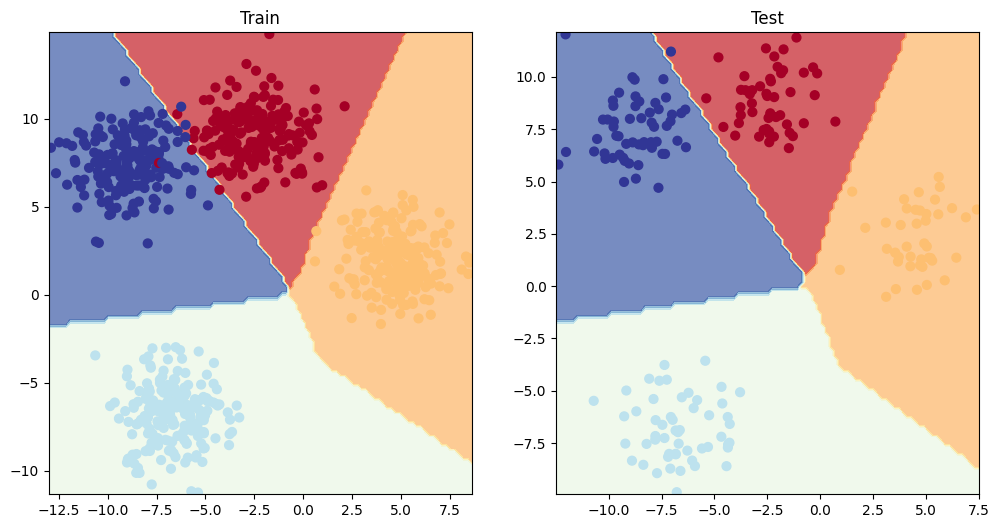

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blob_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blob_model, X_test, y_test)

In [52]:
with torch.inference_mode():
  y_pred_logits = blob_model(X_test)
  y_pred_probs = torch.softmax(y_pred_logits, dim=1).argmax(dim=1).type(torch.float32)

y_pred_probs[:5], y_test[:5]

(tensor([1., 3., 2., 1., 0.]), tensor([1., 3., 2., 1., 0.]))

In [53]:
!pip install torchmetrics

In [54]:
from torchmetrics import Accuracy

accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

accuracy_metric(y_pred_probs, y_test)

tensor(0.9950)